# Pair Trading: Backtest with Backtrader

## Imports & Settings

In [157]:
import csv
import warnings
from collections import defaultdict
from dataclasses import dataclass, asdict
from datetime import date
from pathlib import Path
from time import time

import backtrader as bt
import numpy as np
import pandas as pd
from backtrader.feeds import PandasData

In [158]:
warnings.filterwarnings('ignore')
sns.set_style('dark')
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
idx = pd.IndexSlice

In [159]:
DATA_PATH = Path('..', 'data') 

In [160]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

## Pairs Trading Backtest

### Pairs DataClass

In [142]:
@dataclass
class Pair:
    period: int
    s1: str
    s2: str
    size1: float
    size2: float
    long: bool
    hr: float
    p1: float
    p2: float
    pos1: float
    pos2: float
    exec1: bool = False
    exec2: bool = False
    active: bool = False
    entry_date: date = None
    exit_date: date = None
    entry_spread: float = np.nan
    exit_spread: float = np.nan

    def executed(self):
        return self.exec1 and self.exec2

    def get_constituent(self, name):
        if name == self.s1:
            return 1
        elif name == self.s2:
            return 2
        else:
            return 0

    def compute_spread(self, p1, p2):
        return p1 * self.size1 + p2 * self.size2

    def compute_spread_return(self, p1, p2):
        current_spread = self.compute_spread(p1, p2)
        delta = self.entry_spread - current_spread
        return (delta / (np.sign(self.entry_spread) *
                         self.entry_spread))

### PandasData definition

In [161]:
class CustomData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = ['open', 'high', 'low', 'close', 'volume']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

### Define Trading Strategy

In [258]:
class StatisticalArbitrageCointegration(bt.Strategy):
    params = (('trades', None),
              ('risk_limit', -.2),
              ('verbose', True),
              ('log_file', 'backtest.csv'))

    def __init__(self):
        self.active_pairs = {}
        self.closing_pairs = {}
        self.exposure = []
        self.metrics = []
        self.last_close = {}
        self.cnt = 0
        self.today = None
        self.clear_log()
        self.order_status = dict(enumerate(['Created', 'Submitted', 'Accepted',
                                            'Partial', 'Completed', 'Canceled',
                                            'Expired', 'Margin', 'Rejected']))

    def clear_log(self):
        if Path(self.p.log_file).exists():
            Path(self.p.log_file).unlink()
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow(
                    ['Date', 'Pair', 'Symbol', 'Order #', 'Reason',
                     'Status', 'Long', 'Price', 'Size', 'Position'])

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.date()] + txt.split(','))

    def get_pair_id(self, s1, s2, period):
        return f'{s1}.{s2}.{period}'

    def check_risk_limit(self):
        for pair_id, pair in list(self.active_pairs.items()):
            if pair.active:
                p1 = self.last_close.get(pair.s1)
                p2 = self.last_close.get(pair.s2)
                ret = pair.compute_spread_return(p1, p2)
                if ret < self.p.risk_limit:
                    self.log(f'{pair_id},{pair.s1},{pair.s2},Risk Limit,{ret},')
                    del self.active_pairs[pair_id]
                    self.sell_pair(pair_id, pair)

    def sell_pair(self, pair_id, pair, reason='close'):
        info = {'pair': pair_id, 'type': reason}
        if pair.long:
            o1 = self.sell(data=pair.s1, size=abs(pair.size1), info=info)
            o2 = self.buy(data=pair.s2, size=abs(pair.size2), info=info)
        else:
            o1 = self.buy(data=pair.s1, size=abs(pair.size1), info=info)
            o2 = self.sell(data=pair.s2, size=abs(pair.size2), info=info)
        pair.active = False
        pair.exec1 = pair.exec2 = False
        self.closing_pairs[pair_id] = pair

        self.log(f'{pair_id},{pair.s1},{o1.ref},{reason},Created,{pair.long},,{pair.size1},')
        self.log(f'{pair_id},{pair.s2},{o2.ref},{reason},Created,{pair.long},,{pair.size2},')

    def notify_order(self, order):
        symbol = order.data._name
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            p = order.executed.price
            s = order.executed.size
            order_type = order.info.info['type']
            if order_type in ['open', 'close']:
                pair_id = order.info.info['pair']
                if order_type == 'open':
                    pair = self.active_pairs.get(pair_id)
                else:
                    pair = self.closing_pairs.get(pair_id)
                if pair is None:
                    self.log(f'{pair_id},{symbol},{order.ref},{order_type},Completed (missing),,{p},{s},{p * s}')
                    return
                component = pair.get_constituent(symbol)
                if component == 1:
                    pair.p1 = p
                    pair.exec1 = True
                elif component == 2:
                    pair.p2 = p
                    pair.exec2 = True
                if pair.executed():
                    pair.exec1 = False
                    pair.exec2 = False
                    if order_type == 'open':
                        pair.entry_spread = pair.compute_spread(p1=pair.p1, p2=pair.p2)
                        pair.entry_date = self.today
                        pair.active = True
                    elif order_type == 'close':
                        pair.exit_spread = pair.compute_spread(p1=pair.p1, p2=pair.p2)
                        pair.exit_date = self.today
                        pair.active = False
                        self.closing_pairs.pop(pair_id)
                self.log(f'{pair_id},{symbol},{order.ref},{order_type},Completed,{pair.long},{p},{s},{p * s}')
            else:
                self.log(f',{symbol},{order.ref},{order_type},Completed,,{p},{s},{p * s}')

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            order_type = order.info.info['type']
            self.log(f',{symbol},{order.ref},{order_type},{self.order_status[order.status]},,,,')

    def enter_pairs(self, df, long=True):
        for s1, s2, hr, period in zip(df.s1, df.s2, df.hedge_ratio, df.period):
            pair_id = self.get_pair_id(s1, s2, period)
            if self.active_pairs.get(pair_id):
                continue

            p1 = self.last_close[s1]
            p2 = self.last_close[s2]
            if long:
                size1 = self.target_value / p1
                size2 = hr * size1
            else:
                size2 = self.target_value / p2
                size1 = 1 / hr * size2

            pair = Pair(s1=s1, s2=s2, period=period, size1=size1, size2=size2,
                        pos1=p1 * size1, pos2=p2 * size2,
                        hr=hr, long=long, p1=p1, p2=p2, entry_date=self.today)
            info = {'pair': pair_id, 'type': 'open'}
            if long:
                o1 = self.buy(data=s1, size=size1, info=info)
                o2 = self.sell(data=s2, size=abs(size2), info=info)
            else:
                o1 = self.sell(data=pair.s1, size=abs(pair.size1), info=info)
                o2 = self.buy(data=pair.s2, size=abs(pair.size2), info=info)

            self.active_pairs[pair_id] = pair

            self.log(f'{pair_id},{s1},{o1.ref},Open,Created,{long},{p1},{size1},{pair.pos1}')
            self.log(f'{pair_id},{s2},{o2.ref},Open,Created,{long},{p2},{size2},{pair.pos2}')

    def adjust_pairs(self):
        orders = defaultdict(float)
        pairs = defaultdict(list)
        for pair_id, pair in self.active_pairs.items():
            p1, p2 = self.last_close[pair.s1], self.last_close[pair.s2]
            pos1, pos2 = pair.size1 * p1, pair.size2 * p2

            if pair.long:
                target_size1 = self.target_value / p1
                orders[pair.s1] += target_size1 - pair.size1
                target_size2 = pos2 / pos1 * self.target_value / p2
                orders[pair.s2] += target_size2 - pair.size2
            else:
                target_size2 = self.target_value / p2
                orders[pair.s2] += target_size2 - pair.size2
                target_size1 = pos1 / pos2 * self.target_value / p1
                orders[pair.s1] += target_size1 - pair.size1
            pair.size1 = target_size1
            pair.size2 = target_size2
            pairs[pair.s1].append(pair_id)
            pairs[pair.s2].append(pair_id)

        for symbol, size in orders.items():
            info = {'pairs': pairs[symbol], 'type': 'adjust'}
            if size > 0:
                order = self.buy(symbol, size=size, info=info)
            elif size < 0:
                order = self.sell(symbol, size=abs(size), info=info)
            else:
                continue
            self.log(f',{symbol},{order.ref},Adjust,Created,{size}')

    def prenext(self):
        self.next()

    def next(self):
        self.today = self.datas[0].datetime.date()
        if self.today not in self.p.trades.index:
            return
        self.cnt += 1

        pf = self.broker.get_value()
        cash = self.broker.get_cash()

        exp = {d._name: pos.size for d, pos in self.getpositions().items() if pos}
        self.last_close = {d._name: d.close[0] for d in self.datas}
        exposure = pd.DataFrame({'price'   : pd.Series(self.last_close),
                                 'position': pd.Series(exp)}).replace(0, np.nan).dropna()
        exposure['value'] = exposure.price * exposure.position
        positions = exposure.value.to_dict()
        positions['date'] = self.today
        positions['cash'] = cash
        if not exposure.empty:
            self.exposure.append(positions)
            long_pos = exposure[exposure.value > 0].value.sum()
            short_pos = exposure[exposure.value < 0].value.sum()
            for symbol, row in exposure.iterrows():
                self.log(f',{symbol},,Positions,Log,,{row.price},{row.position},{row.value}')
        else:
            long_pos = short_pos = 0

        trades = self.p.trades.loc[self.today]
        if isinstance(trades, pd.Series):
            trades = trades.to_frame().T

        close = trades[trades.side == 0].sort_values('period')
        for s1, s2, period in zip(close.s1, close.s2, close.period):
            pair_id = self.get_pair_id(s1, s2, period)
            pair = self.active_pairs.pop(pair_id, None)
            if pair is None:
                self.log(f'{pair_id},,,Close Attempt,Failed,,,,')
                continue
            self.sell_pair(pair_id, pair)

        if len(self.active_pairs) > 0:
            self.check_risk_limit()

        long = trades[trades.side == 1]
        short = trades[trades.side == -1]
        if long.empty and short.empty: return
        target = 1 / (len(long) + len(short) + len(self.active_pairs))
        self.target_value = pf * target
        metrics = [self.today, pf, pf - cash, cash, len(exposure), len(self.active_pairs), long_pos, short_pos,
                   target, self.target_value, len(long), len(short), len(close)]
        self.metrics.append(metrics)
        if self.cnt % 21 == 0:
            holdings = pf - cash
            msg = f'PF: {pf:11,.0f} | Net: {holdings: 11,.0f} | # Pos: {len(exposure):3,.0f} | # Pairs: {len(self.active_pairs):3,.0f} | '
            msg += f'Long: {long_pos: 10,.0f} | Short: {short_pos: 10,.0f}'
            print(self.today, msg)

        self.adjust_pairs()

        if not long.empty:
            self.enter_pairs(long, long=True)

        if not short.empty:
            self.enter_pairs(short, long=False)

### Load Trades

In [316]:
trades = pd.read_hdf('backtest.h5', 'pair_trades').sort_index()
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183727 entries, 2017-01-03 to 2019-12-11
Data columns (total 6 columns):
s1             183727 non-null object
s2             183727 non-null object
hedge_ratio    183727 non-null float64
period         183727 non-null int64
pair           183727 non-null int64
side           183727 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.8+ MB


In [317]:
trade_dates = np.unique(trades.index)
start = trade_dates.min()
end = trade_dates.max()
traded_symbols = trades.s1.append(trades.s2).unique()

### Load Prices

In [318]:
prices = (pd.read_hdf('backtest.h5', 'prices')
              .sort_index()
              .loc[idx[traded_symbols, str(start): str(end)], :])

### Configure Cerebro

In [319]:
cerebro = bt.Cerebro()
cash = 1000000
cerebro.broker.setcash(cash)

### Add Data

In [320]:
for symbol in traded_symbols:
    df = prices.loc[idx[symbol, :], :].droplevel('symbol', axis=0)
    df.index.name = 'datetime'
    bt_data = CustomData(dataname=df)
    cerebro.adddata(bt_data, name=symbol)

### Add Strategy & Analyzer

In [321]:
cerebro.addstrategy(StatisticalArbitrageCointegration,
                    trades=trades, verbose=True,
                    log_file='bt_log.csv')

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

### Run Strategy

In [322]:
start = time()
results = cerebro.run()

ending_value = cerebro.broker.getvalue()
duration = time() - start

print(f'Final Portfolio Value: {ending_value:,.2f} | Duration: {format_time(duration)}')

2017-02-01 PF:     998,620 | Net:      19,549 | # Pos: 279 | # Pairs: 394 | Long:    706,054 | Short:   -686,506
2017-03-03 PF:   1,011,908 | Net:      37,443 | # Pos: 285 | # Pairs: 424 | Long:    721,144 | Short:   -683,701
2017-04-03 PF:   1,018,451 | Net:       6,626 | # Pos: 288 | # Pairs: 616 | Long:    706,282 | Short:   -699,656
2017-05-03 PF:   1,012,221 | Net:      72,392 | # Pos: 284 | # Pairs: 237 | Long:    785,122 | Short:   -712,729
2017-06-02 PF:     993,809 | Net:     101,252 | # Pos: 281 | # Pairs: 287 | Long:    825,167 | Short:   -723,916
2017-07-03 PF:     962,131 | Net:      63,296 | # Pos: 289 | # Pairs: 195 | Long:    814,352 | Short:   -751,056
2017-08-02 PF:     988,445 | Net:      71,745 | # Pos: 301 | # Pairs: 591 | Long:    660,460 | Short:   -588,715
2017-08-31 PF:     992,311 | Net:      47,471 | # Pos: 299 | # Pairs: 291 | Long:    780,180 | Short:   -732,709
2017-10-02 PF:   1,030,517 | Net:      30,137 | # Pos: 301 | # Pairs: 249 | Long:    822,224 | S

### Get PyFolio Inputs

In [323]:
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

In [324]:
STORE = 'backtrader.h5'
returns.to_hdf(STORE, 'returns')
positions.to_hdf(STORE, 'positions')
transactions.to_hdf(STORE, 'transactions/')
gross_lev.to_hdf(STORE, 'gross_lev')

### Get Positions

The PyFolio integration is somewhat broken due to API changes after version 0.5.1 so we need to retrieve the positions manually.

In [325]:
positions = pd.DataFrame(results[0].exposure)
positions.date = pd.to_datetime(positions.date)
positions = positions.set_index('date').tz_localize('UTC')
positions.info()
traded_pairs.to_hdf(STORE, 'traded_pairs')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 2017-01-04 00:00:00+00:00 to 2019-12-11 00:00:00+00:00
Columns: 303 entries, AAPL to cash
dtypes: float64(303)
memory usage: 1.7 MB


### Get Metrics

In [326]:
metrics = pd.DataFrame(results[0].metrics,
                       columns=['date', 'pf', 'net_holdings', 'cash',
                                'npositions', 'npairs', 'nlong_pos', 'nshort_pos',
                                'target', 'target_val', 'nlong_trades',
                                'nshort_trades', 'nclose_trades'])
metrics.to_hdf(STORE, 'metrics')

## Run PyFolio Analysis

In [327]:
returns = pd.read_hdf(STORE, 'returns')
transactions = pd.read_hdf(STORE, 'transactions/')
gross_lev = pd.read_hdf(STORE, 'gross_lev')
metrics = pd.read_hdf(STORE, 'metrics').set_index('date')

In [328]:
metrics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 679 entries, 2017-01-03 to 2019-09-30
Data columns (total 12 columns):
pf               679 non-null float64
net_holdings     679 non-null float64
cash             679 non-null float64
npositions       679 non-null int64
npairs           679 non-null int64
nlong_pos        679 non-null float64
nshort_pos       679 non-null float64
target           679 non-null float64
target_val       679 non-null float64
nlong_trades     679 non-null int64
nshort_trades    679 non-null int64
nclose_trades    679 non-null int64
dtypes: float64(7), int64(5)
memory usage: 69.0+ KB


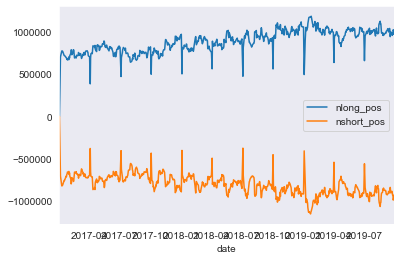

In [334]:
metrics[['nlong_pos', 'nshort_pos']].plot();

### Get Benchmark

In [329]:
start = str(returns.index.min().year)
end = str(returns.index.max().year +1)

In [330]:
benchmark = web.DataReader('SP500', 'fred', start=start, end=end).squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

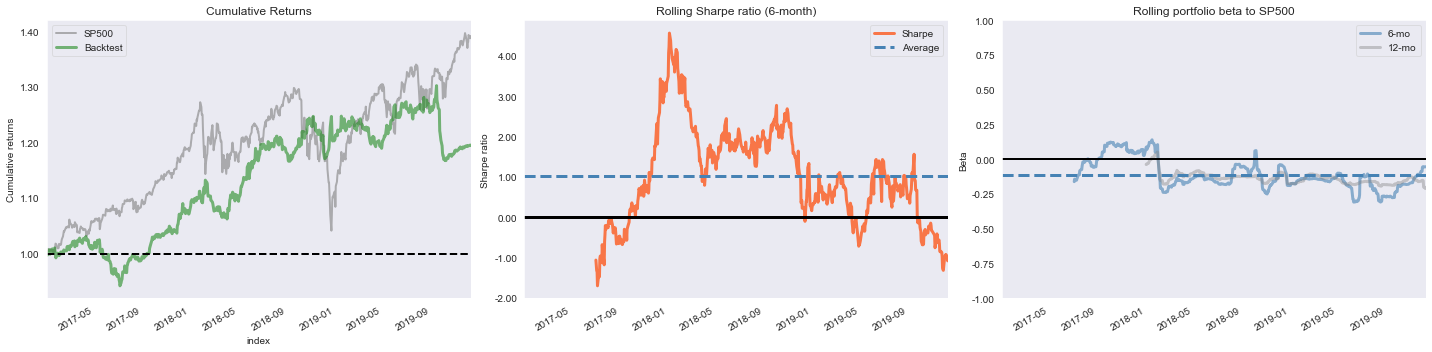

In [331]:
fig, axes = plt.subplots(ncols=3, figsize=(20,5))
pf.plotting.plot_rolling_returns( returns, factor_returns=benchmark, ax=axes[0])
axes[0].set_title('Cumulative Returns')
pf.plotting.plot_rolling_sharpe(returns, ax=axes[1])
pf.plotting.plot_rolling_beta(returns, benchmark, ax=axes[2])
fig.tight_layout()
fig.savefig('figures/performance');

### Create full tearsheet

Start date,2017-01-03
End date,2019-12-11
Total months,35
,Backtest
Annual return,6.3%
Cumulative returns,19.5%
Annual volatility,8.6%
Sharpe ratio,0.75
Calmar ratio,0.60
Stability,0.83
Max drawdown,-10.4%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.36,2019-09-16,2019-10-09,NaT,NaN
1,8.59,2017-04-12,2017-07-07,2017-10-05,127
2,6.17,2018-02-08,2018-04-04,2018-05-16,70
3,6.12,2018-11-08,2018-12-07,2019-01-18,52
4,4.64,2019-01-18,2019-04-30,2019-05-30,95


Stress Events,mean,min,max
New Normal,0.03%,-3.17%,1.95%


Top 10 long positions of all time,max
TMF,16.41%
BIIB,15.67%
ALXN,14.99%
SCO,13.94%
BHC,12.23%
DUG,11.84%
MDLZ,11.61%
WMB,11.42%
BB,10.98%
CMG,10.42%


Top 10 short positions of all time,max
WBA,-13.52%
LLY,-12.63%
DUG,-12.20%
CVS,-12.18%
MDLZ,-11.89%
ALXN,-11.63%
SCO,-11.31%
CI,-11.21%
BIIB,-11.16%
UCO,-9.78%


Top 10 positions of all time,max
TMF,16.41%
BIIB,15.67%
ALXN,14.99%
SCO,13.94%
WBA,13.52%
LLY,12.63%
BHC,12.23%
DUG,12.20%
CVS,12.18%
MDLZ,11.89%


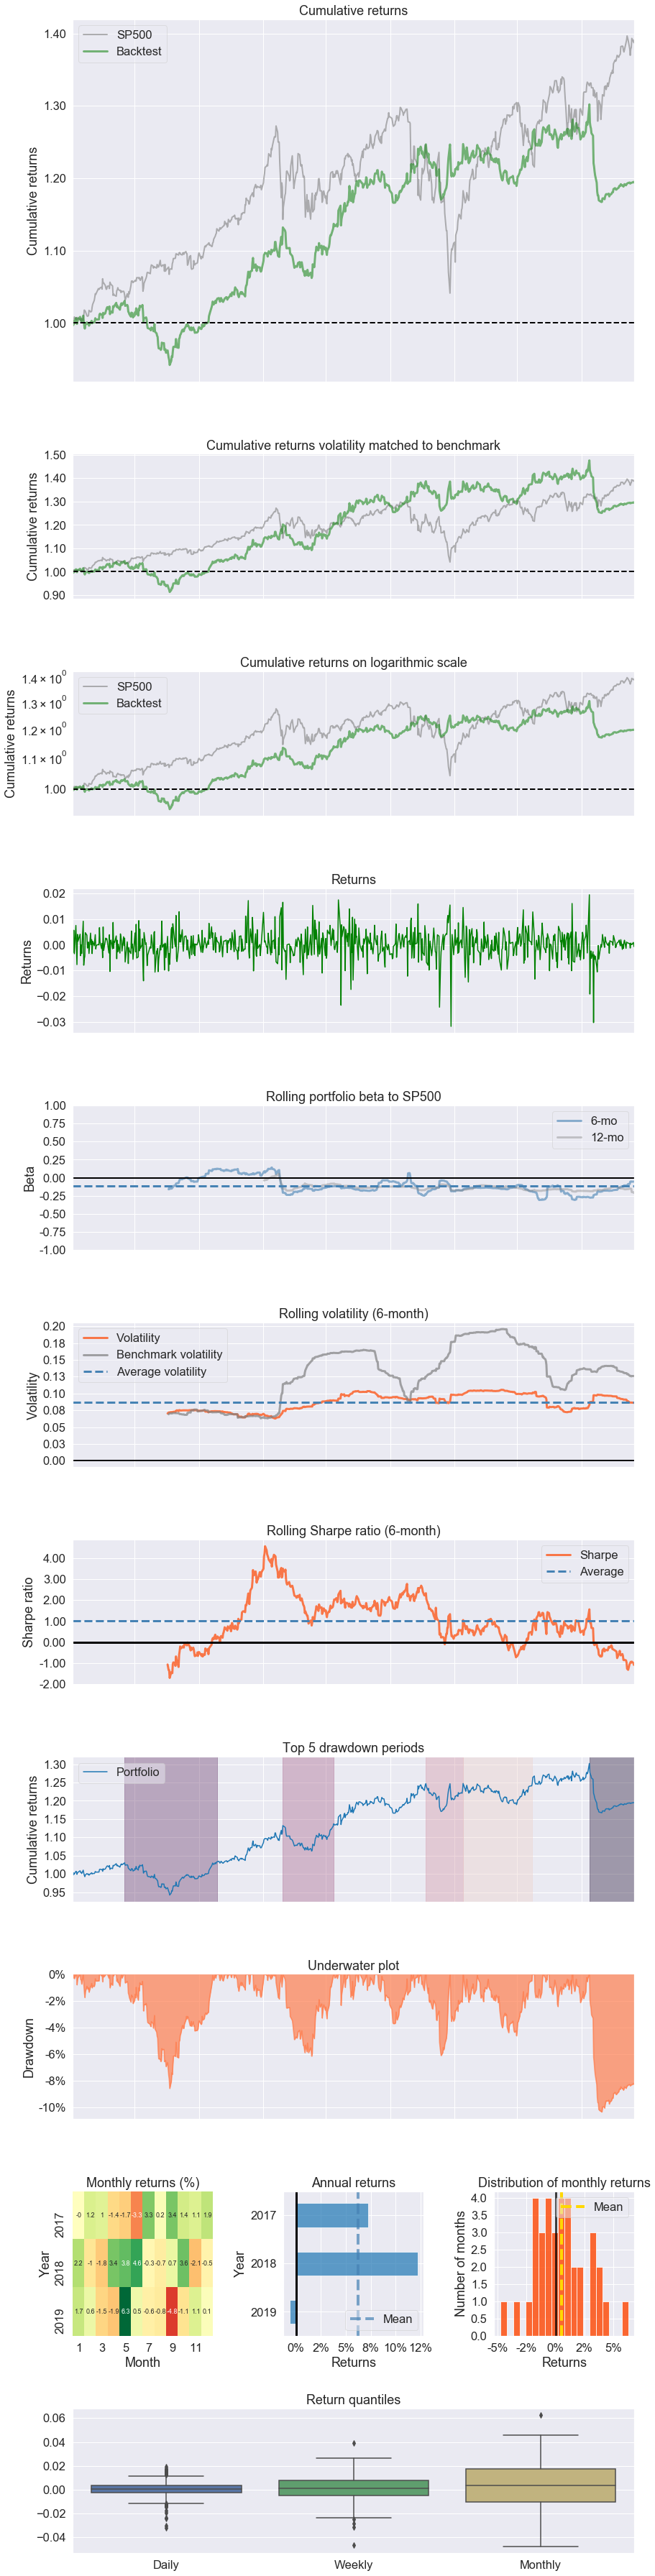

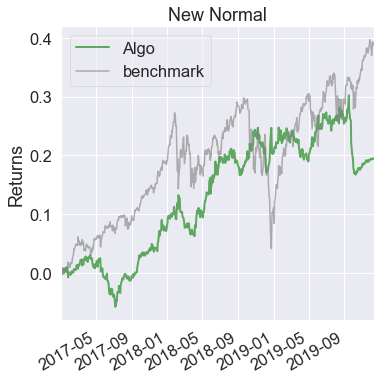

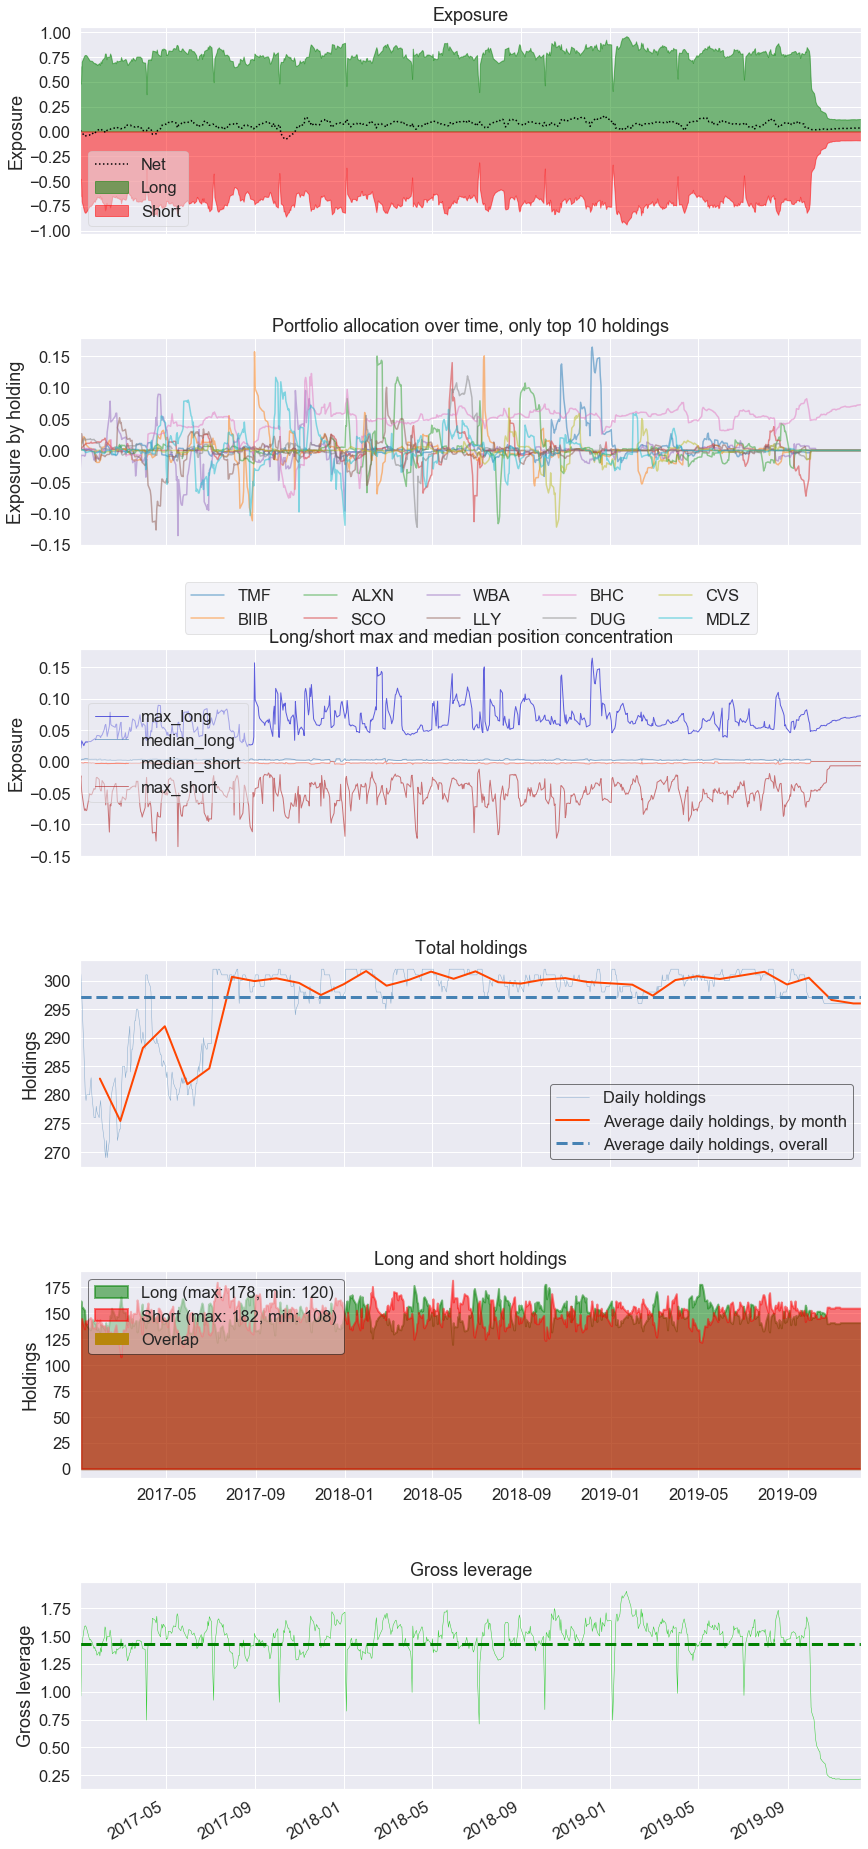

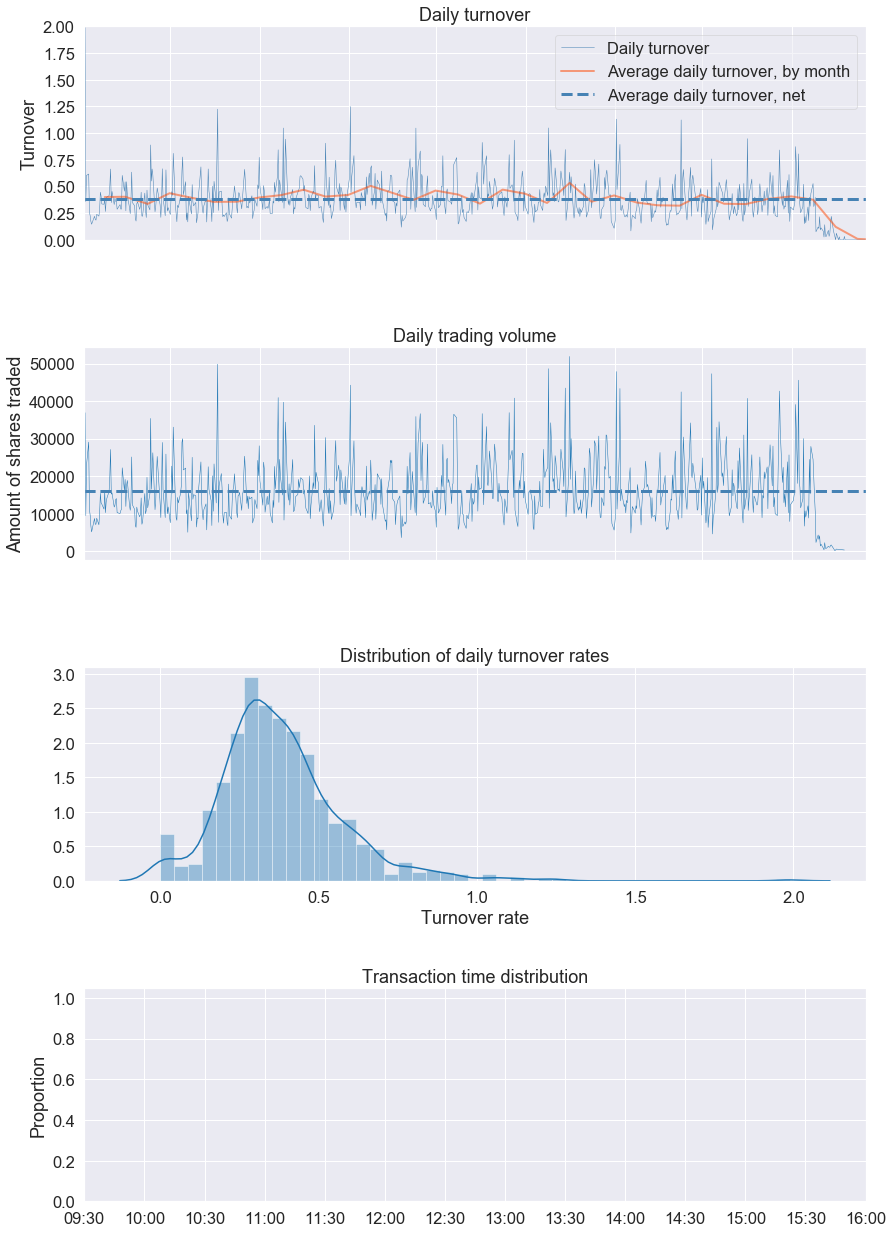

In [332]:
pf.create_full_tear_sheet(returns,
                          positions=positions,
                          transactions=transactions,
                          benchmark_rets=benchmark.loc[returns.index],
                          estimate_intraday=False)